This code: merges CSV files, shows which days and hours are in the collective database, creates df, converts x, y, values in to date-time and price including VAT and energy tax (2025).it shows the development of price predictions for the period -4 hours till 7 x 24 hours in the future.


# there is an issue with merging process and timestamps requiering resolution

In [10]:
# combine all prediction files into a single database
import os
import pandas as pd
import glob
from pathlib import Path
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the folder containing the CSV files
folder_path = Path("oxygent_data")

# Get all CSV files in the folder
csv_files = list(folder_path.glob("*.csv")) + list(folder_path.glob("*.CSV"))

# Sort files based on timestamp in filename
csv_files.sort(key=lambda x: x.stem.split("_")[-1].replace(":", ""))

# Read and concatenate all CSV files
df_list = []
for file in csv_files:
    try:
        df = pd.read_csv(file)
        df_list.append(df)
        logging.info(f"Successfully read {file}")
    except Exception as e:
        logging.error(f"Error reading {file}: {e}")

if df_list:
    merged_df = pd.concat(df_list, ignore_index=True)

    # Save the merged data
    output_file = "merged_data_price_preds.csv"
    merged_df.to_csv(output_file, index=False)
    logging.info(f"Merged {len(csv_files)} files into '{output_file}'")
else:
    logging.warning("No files were read successfully.")

2025-03-23 20:43:55,448 - INFO - Successfully read oxygent_data/time_series_data_20250225_00:04.csv
2025-03-23 20:43:55,450 - INFO - Successfully read oxygent_data/time_series_data_20250314_0030.csv
2025-03-23 20:43:55,451 - INFO - Successfully read oxygent_data/time_series_data_20250315_0030.csv
2025-03-23 20:43:55,452 - INFO - Successfully read oxygent_data/time_series_data_20250313_0030.csv
2025-03-23 20:43:55,453 - INFO - Successfully read oxygent_data/time_series_data_20250316_0031.csv
2025-03-23 20:43:55,454 - INFO - Successfully read oxygent_data/time_series_data_20250225_01:04.csv
2025-03-23 20:43:55,455 - INFO - Successfully read oxygent_data/time_series_data_20250313_0130.csv
2025-03-23 20:43:55,456 - INFO - Successfully read oxygent_data/time_series_data_20250314_0130.csv
2025-03-23 20:43:55,457 - INFO - Successfully read oxygent_data/time_series_data_20250315_0130.csv
2025-03-23 20:43:55,458 - INFO - Successfully read oxygent_data/time_series_data_20250316_0131.csv
2025-03-

In [11]:
# Generate descriptive statistics for the merged data
descriptive_stats = merged_df.describe()

# Print the descriptive statistics
print(descriptive_stats)
print(merged_df)

                  x              y       subarray
count  6.601590e+05  660159.000000  660159.000000
mean   1.741813e+07       0.101659       2.855812
std    6.970762e+03       0.062893       1.521727
min    1.740352e+07      -0.213000       0.000000
25%    1.741248e+07       0.066000       2.000000
50%    1.741835e+07       0.106000       3.000000
75%    1.742368e+07       0.141000       4.000000
max    1.743361e+07       0.365000       5.000000
                 x        y                         timestamp  subarray
0       17403516.0  0.01000  2025-02-25T00:04:11.929962+00:00         0
1       17403552.0  0.01189  2025-02-25T00:04:11.929962+00:00         0
2       17403588.0  0.01243  2025-02-25T00:04:11.929962+00:00         0
3       17403624.0  0.00768  2025-02-25T00:04:11.929962+00:00         0
4       17403660.0  0.00393  2025-02-25T00:04:11.929962+00:00         0
...            ...      ...                               ...       ...
660154  17426700.0  0.09600  2025-03-15T23:31:

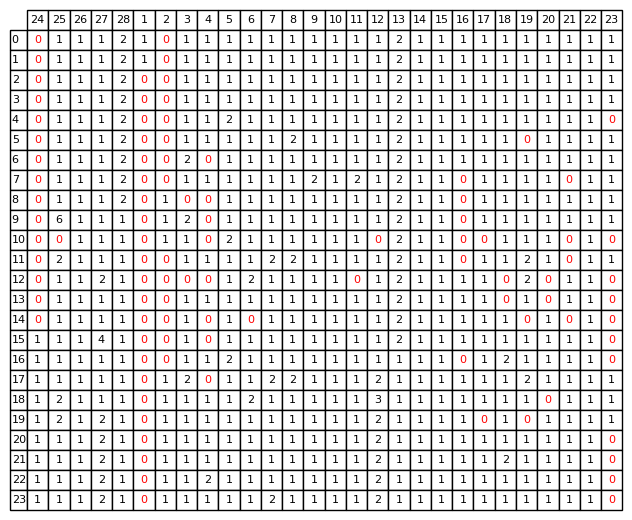

In [12]:
# pivot table to visualize extend of database
# 
# Convert the 'timestamp' column to datetime in ISO 8601 format
merged_df['timestamp_iso'] = pd.to_datetime(merged_df['timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%S.%f%z')

# Extract dates from the 'timestamp_iso' column
merged_df['date_timestamp'] = pd.to_datetime(merged_df['timestamp_iso']).dt.date
# Extract hour from the 'timestamp_iso' column
merged_df['hour_timestamp'] = pd.to_datetime(merged_df['timestamp_iso']).dt.hour

# Create a pivot table to show unique combinations of hour_timestamp and date_timestamp
pivot_table = merged_df.pivot_table(index='hour_timestamp', columns='date_timestamp', values='timestamp', aggfunc='nunique', fill_value=0)

# Convert column index to datetime and extract the day
pivot_table.columns = pd.to_datetime(pivot_table.columns).day

# Print the pivot table with grids and highlight count values of '0' in red font
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=pivot_table.values, colLabels=pivot_table.columns, rowLabels=pivot_table.index, cellLoc='center', loc='center')

# Apply styles to the table
for (i, j), cell in table.get_celld().items():
    cell.set_edgecolor('black')
    if i > 0 and j > -1 and pivot_table.iat[i-1, j] == 0:
        cell.set_text_props(color='red')


table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.2)



plt.show()

In [13]:
#creating a leaner dataframe, excluding non-relevant columns
lean_df = merged_df.drop(columns=['timestamp', 'timestamp_iso'])
print(lean_df.columns)
print(lean_df.head)

Index(['x', 'y', 'subarray', 'date_timestamp', 'hour_timestamp'], dtype='object')
<bound method NDFrame.head of                  x        y  subarray date_timestamp  hour_timestamp
0       17403516.0  0.01000         0     2025-02-25               0
1       17403552.0  0.01189         0     2025-02-25               0
2       17403588.0  0.01243         0     2025-02-25               0
3       17403624.0  0.00768         0     2025-02-25               0
4       17403660.0  0.00393         0     2025-02-25               0
...            ...      ...       ...            ...             ...
660154  17426700.0  0.09600         5     2025-03-15              23
660155  17426736.0  0.08400         5     2025-03-15              23
660156  17426772.0  0.08300         5     2025-03-15              23
660157  17426808.0  0.07100         5     2025-03-15              23
660158  17426844.0  0.05600         5     2025-03-15              23

[660159 rows x 5 columns]>


In [14]:
from datetime import datetime

#conversion of x to datetime
def add_datetime_column(df):
    # Convert x values to milliseconds and then to datetime
    lean_df['date_time'] = lean_df['x'].apply(lambda x: datetime.fromtimestamp(x * 100000 / 1000))
    return df

# Assuming df is already defined in the previous cell
lean_df['Price'] = lean_df['y'].apply(lambda y: (y * 1.21) + 0.1228)  # Calculate price values

# Add the date_time column
lean_df = add_datetime_column(lean_df)

print(lean_df.columns)
print(lean_df.head(2))
print(lean_df.tail(2))


Index(['x', 'y', 'subarray', 'date_timestamp', 'hour_timestamp', 'Price',
       'date_time'],
      dtype='object')
            x        y  subarray date_timestamp  hour_timestamp     Price  \
0  17403516.0  0.01000         0     2025-02-25               0  0.134900   
1  17403552.0  0.01189         0     2025-02-25               0  0.137187   

            date_time  
0 2025-02-24 00:00:00  
1 2025-02-24 01:00:00  
                 x      y  subarray date_timestamp  hour_timestamp    Price  \
660157  17426808.0  0.071         5     2025-03-15              23  0.20871   
660158  17426844.0  0.056         5     2025-03-15              23  0.19056   

                 date_time  
660157 2025-03-22 23:00:00  
660158 2025-03-23 00:00:00  


In [15]:
# Reorder rows based on date_timestamp and hour_timestamp in ascending order
lean_df = lean_df.sort_values(by=['date_timestamp', 'hour_timestamp'], ascending=[True, True])

print("head values")
print(lean_df.head(2))
print()
print("tail values ")
print(lean_df.tail(2))

head values
                x        y  subarray date_timestamp  hour_timestamp     Price  \
80746  17403516.0  0.01000         0     2025-02-24              15  0.134900   
80747  17403552.0  0.01189         0     2025-02-24              15  0.137187   

                date_time  
80746 2025-02-24 00:00:00  
80747 2025-02-24 01:00:00  

tail values 
                 x      y  subarray date_timestamp  hour_timestamp    Price  \
642030  17433576.0  0.073         5     2025-03-23              19  0.21113   
642031  17433612.0  0.065         5     2025-03-23              19  0.20145   

                 date_time  
642030 2025-03-30 20:00:00  
642031 2025-03-30 21:00:00  


In [16]:
from datetime import datetime

# Filter lean_df to create point_est_price_df, only showing subarray 1
point_est_price_df = lean_df[lean_df['subarray'] == 1]

# Get the current time
current_time = datetime.now()

# Filter the DataFrame to only include rows with date_time values greater than the current time
future_prices = point_est_price_df[point_est_price_df['date_time'] > current_time]

# Get the 10 rows with the lowest price values, sorted by date_time
lowest_future_price_rows = future_prices.nsmallest(10, 'Price').sort_values(by='date_time')

print("Rows with the 10 lowest price values, in chronological order, with date_time values > current time:")
print(lowest_future_price_rows)

Rows with the 10 lowest price values, in chronological order, with date_time values > current time:
                 x      y  subarray date_timestamp  hour_timestamp    Price  \
614871  17432424.0 -0.021         1     2025-03-22              10  0.09739   
615940  17432424.0 -0.021         1     2025-03-22              11  0.09739   
615941  17432460.0 -0.049         1     2025-03-22              11  0.06351   
628830  17432496.0 -0.017         1     2025-03-23               0  0.10223   
629849  17432496.0 -0.017         1     2025-03-23               1  0.10223   
630873  17432496.0 -0.017         1     2025-03-23               2  0.10223   
631902  17432496.0 -0.017         1     2025-03-23               3  0.10223   
632936  17432496.0 -0.017         1     2025-03-23               5  0.10223   
633980  17432496.0 -0.017         1     2025-03-23               6  0.10223   
638244  17433324.0 -0.020         1     2025-03-23              11  0.09860   

                 date_time  
6

In [17]:


# Print the head and tail rows of point_est_price_df
print("head values")
print(point_est_price_df.head(2))
print()
print("tail values")
print(point_est_price_df.tail(2))

head values
                x      y  subarray date_timestamp  hour_timestamp    Price  \
80795  17403516.0  0.152         1     2025-02-24              15  0.30672   
80796  17403552.0  0.145         1     2025-02-24              15  0.29825   

                date_time  
80795 2025-02-24 00:00:00  
80796 2025-02-24 01:00:00  

tail values
                 x      y  subarray date_timestamp  hour_timestamp    Price  \
641274  17433576.0  0.093         1     2025-03-23              19  0.23533   
641275  17433612.0  0.083         1     2025-03-23              19  0.22323   

                 date_time  
641274 2025-03-30 20:00:00  
641275 2025-03-30 21:00:00  


// Price values match price shown on energie.theoxigent.nl, re-confirmed by checking price values most into the future. Based on CSV file 'oxygent_data/time_series_data_20250317 12:45.csv' //


/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_63834/3447898692.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('coolwarm', len(unique_combinations))


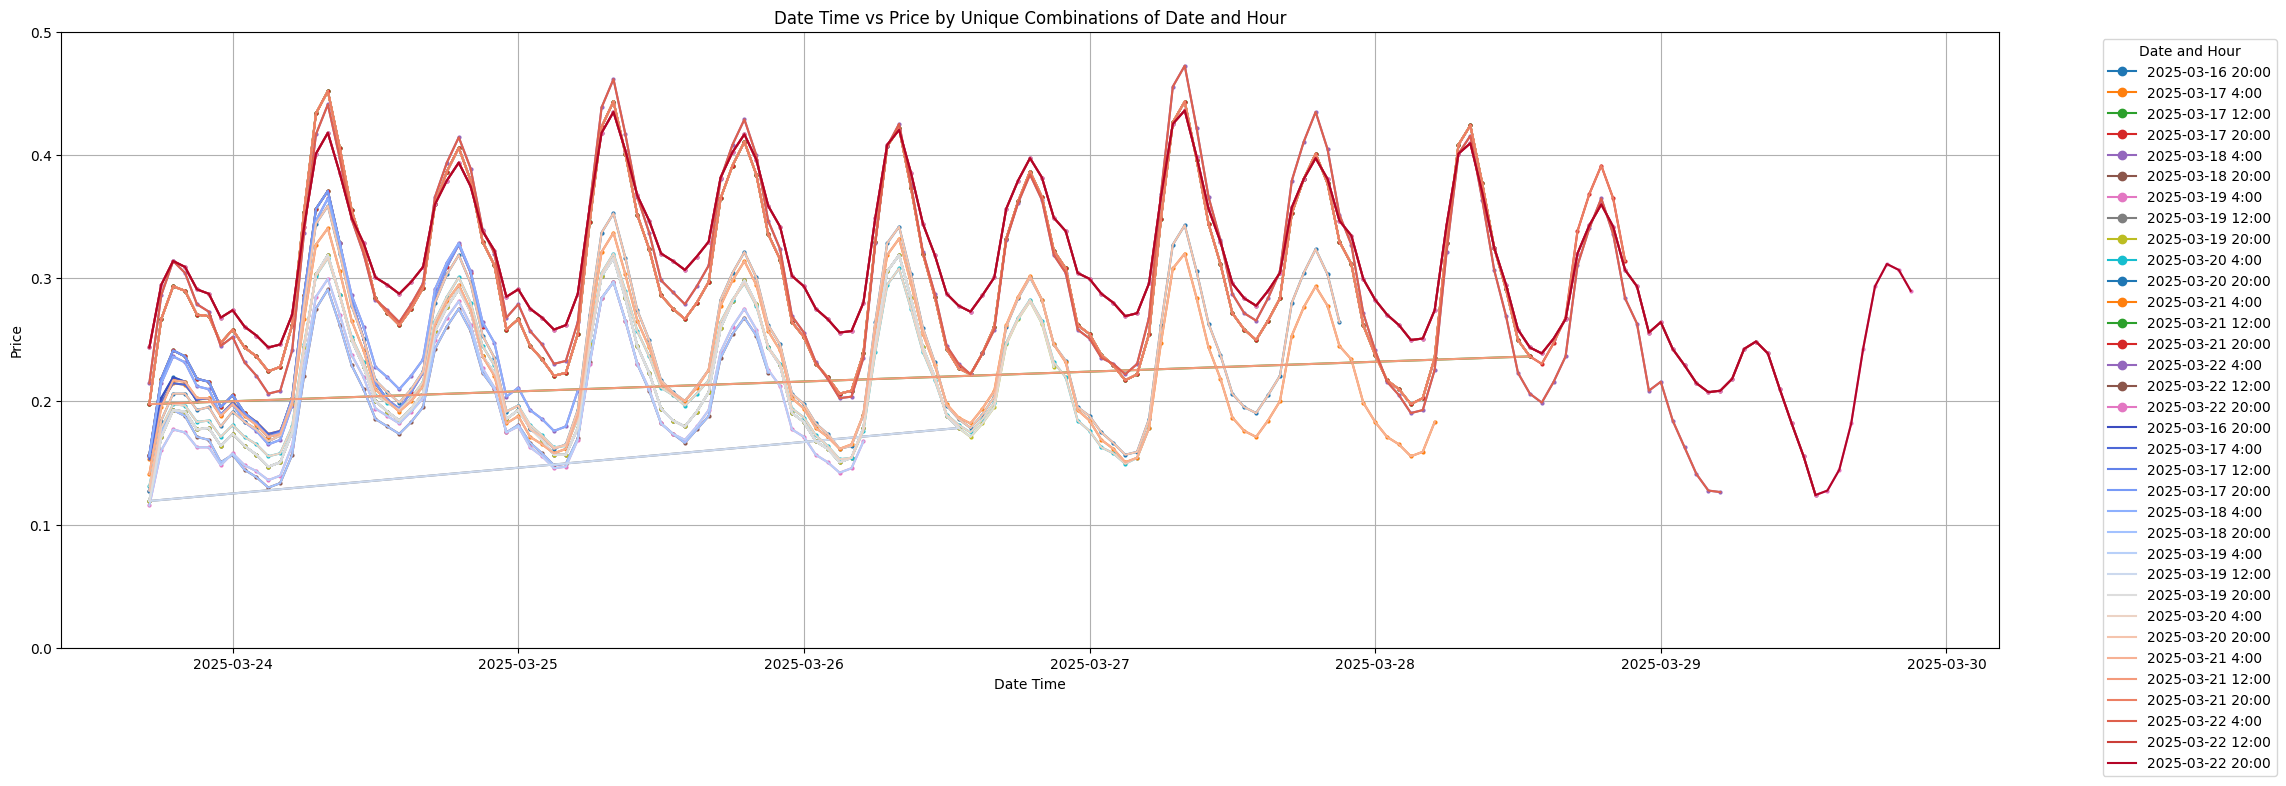

In [18]:
#  how estimate evolve for a particular time period
import matplotlib.pyplot as plt
import datetime
import numpy as np

# Define the time range
start_time = datetime.datetime.now() - datetime.timedelta(hours=4)
end_time = datetime.datetime.now() + datetime.timedelta(days=7)

# Filter the DataFrame based on the time range
filtered_df = point_est_price_df[(point_est_price_df['date_time'] >= start_time) & (point_est_price_df['date_time'] <= end_time)]

# Further filter the DataFrame to only include hour_timestamp values equal to 12 or 4 or 20
filtered_df = filtered_df[(filtered_df['hour_timestamp'] == 4) | (filtered_df['hour_timestamp'] == 12) | (filtered_df['hour_timestamp'] == 20)]

# Plot the filtered data by each unique combination of date_timestamp and hour_timestamp
unique_combinations = filtered_df.groupby(['date_timestamp', 'hour_timestamp'])

plt.figure(figsize=(25, 8))  # Adjust the width to be 5 times wider

for (date_timestamp, hour_timestamp), group in unique_combinations:
    plt.plot(group['date_time'], group['Price'], marker='o', label=f'{date_timestamp} {hour_timestamp}:00')

import matplotlib.cm as cm
# Generate a color map from red to blue
colors = cm.get_cmap('coolwarm', len(unique_combinations))

for i, ((date_timestamp, hour_timestamp), group) in enumerate(unique_combinations):
    plt.plot(group['date_time'], group['Price'], color=colors(i), label=f'{date_timestamp} {hour_timestamp}:00')

plt.xlabel('Date Time')
plt.ylabel('Price')
plt.title('Date Time vs Price by Unique Combinations of Date and Hour')
plt.ylim(0.0, 0.5)  # Set y-axis limits
plt.legend(title='Date and Hour', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Change the format to dots being 3x smaller
for line in plt.gca().get_lines():
    line.set_markersize(line.get_markersize() / 3)

plt.show()
